# importing libraries....

In [66]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding
import warnings
import random
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from tensorflow.keras import layers
from keras.utils import to_categorical

In [2]:
# filter warnings...
warnings.filterwarnings("ignore")

# EDA

In [3]:
# getting the data
train = pd.read_csv("tweet-sentiment-extraction/train.csv")
test = pd.read_csv("tweet-sentiment-extraction/test.csv")
sub = pd.read_csv("tweet-sentiment-extraction/sample_submission.csv")
# train data head....
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
# test data head....
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [5]:
# submissive data...
sub.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [6]:
# train data shape
train.shape

(27481, 4)

In [7]:
# data info....
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
# looking for null values...
train.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [9]:
# as there is onyl single null value in training set, so it's better to drop it...
train.dropna(inplace=True)

In [10]:
# looking for null value in test set..
test.isna().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [11]:
# target label distribution....
sentiment = train["sentiment"].value_counts()
sentiment

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [12]:
# setting the plot style...
plt.style.use("ggplot")

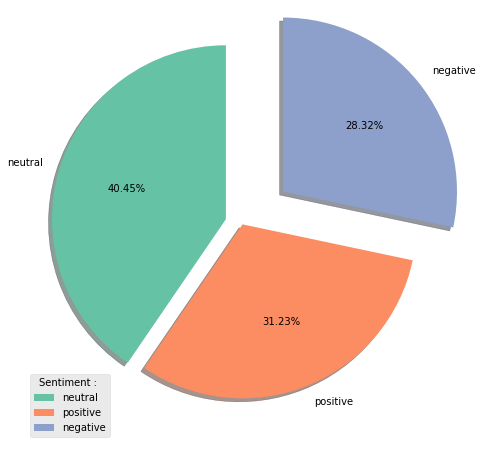

In [13]:
# plot the sentiment distribution...
plt.figure(figsize=(10,8))
labels = sentiment.index
colors = sns.color_palette("Set2")
explode = [0.1,0,0.3]
plt.pie(sentiment,labels = labels, colors = colors, explode = explode,
       autopct = "%.2f%%", startangle = 90, shadow = True)
plt.legend(title = "Sentiment : ")
plt.show()

In [14]:
# test data target label distribution
test_sentiment = test.sentiment.value_counts()
test_sentiment

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

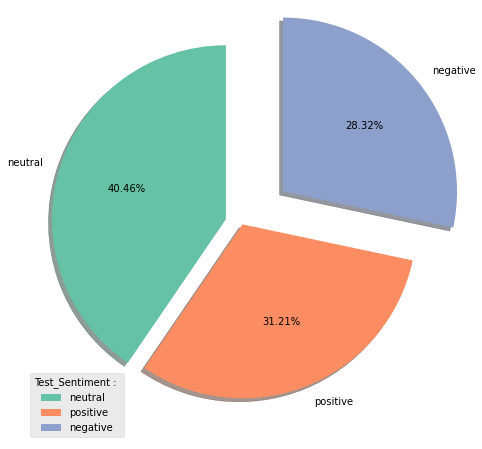

In [15]:
# plot the sentiment distribution...
plt.figure(figsize=(10,8))
labels = test_sentiment.index
colors = sns.color_palette("Set2")
explode = [0.1,0,0.3]
plt.pie(test_sentiment,labels = labels, colors = colors, explode = explode,
       autopct = "%.2f%%", startangle = 90, shadow = True)
plt.legend(title = "Test_Sentiment : ")
plt.show()

In [16]:
# changing the data-type...
train["text"] =  train["text"].astype("string")

In [17]:
# checking the length of the selected text...
train["length"] = train["text"].apply(lambda x: len(x.split()))
train.head()

,textID,text,selected_text,sentiment,length
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14


In [18]:
# checking the length of test text data
test["length"] = test["text"].apply(lambda x: len(x.split()))
test

,textID,text,sentiment,length
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,6
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,15
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,13
3,01082688c6,happy bday!,positive,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,5
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,15
3530,416863ce47,All alone in this old house again. Thanks for...,positive,26
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,18
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,14


In [19]:
print(f"Max length of tweet text in training set : {train['length'].max()}")
print(f"Min lenght of tweet text in training set. : {train['length'].min()}")
print(f"Max length of tweet text in test set : {test['length'].max()}")
print(f"Min lenght of tweet text in test set. : {test['length'].min()}")

Max length of tweet text in training set : 33
Min lenght of tweet text in training set. : 1
Max length of tweet text in test set : 32
Min lenght of tweet text in test set. : 1


In [20]:
print(f"Shortest tweets in training set : \n{train[train['length']==min(train['length'])]}")

Shortest tweets in training set : 
           textID           text selected_text sentiment  length
42     2e7082d1c8       MAYDAY?!      MAYDAY?!   neutral       1
68     fa2654e730       Chilliin      Chilliin  positive       1
127    8e1583cb08     Absolutely    Absolutely   neutral       1
224    f3a77c2b5e       _nesmith      _nesmith   neutral       1
238    e98226e842            Thx           Thx   neutral       1
...           ...            ...           ...       ...     ...
26690  e80c242d6a     Goodnight;    Goodnight;  positive       1
26693  7dc13f50d8   yessssssir!!  yessssssir!!   neutral       1
26726  aad244f37d          *hug*         *hug*  positive       1
26754  b6f6bd82c0       careless      careless  negative       1
26843  a46571fe12      congrats!     congrats!  positive       1

[199 rows x 5 columns]


In [21]:
print(f"longest tweets in training set : \n{train[train['length']==max(train['length'])]}")

longest tweets in training set : 
           textID                                               text  \
19887  ede80b9f63  AK, flop comes 2K6 I bet 15 get raised to 25 I...   
25359  be445111e7  : Lol it went okay! As far as I can tell . But...   

                                           selected_text sentiment  length  
19887  AK, flop comes 2K6 I bet 15 get raised to 25 I...   neutral      33  
25359                               Lol it went okay! As  positive      33  


<Figure size 720x576 with 0 Axes>

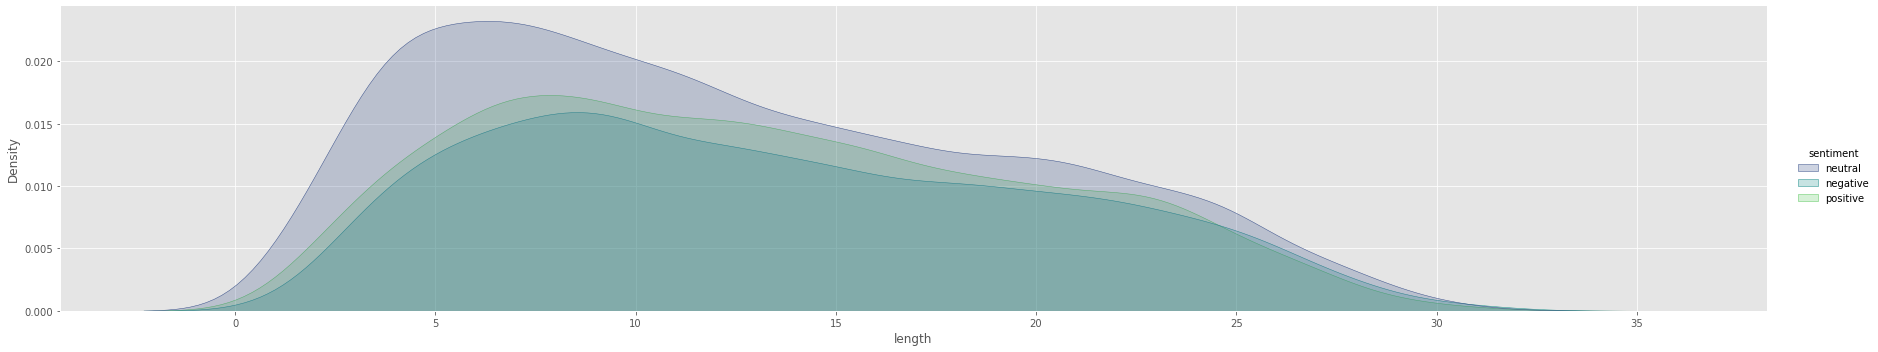

In [22]:
# plot the length of tweet text across the sentiment....
plt.figure(figsize=(10,8))
sns.displot(data = train, x = "length", hue = "sentiment",
           kind = "kde", fill = True, aspect = 5, palette = "viridis");

<Figure size 720x576 with 0 Axes>

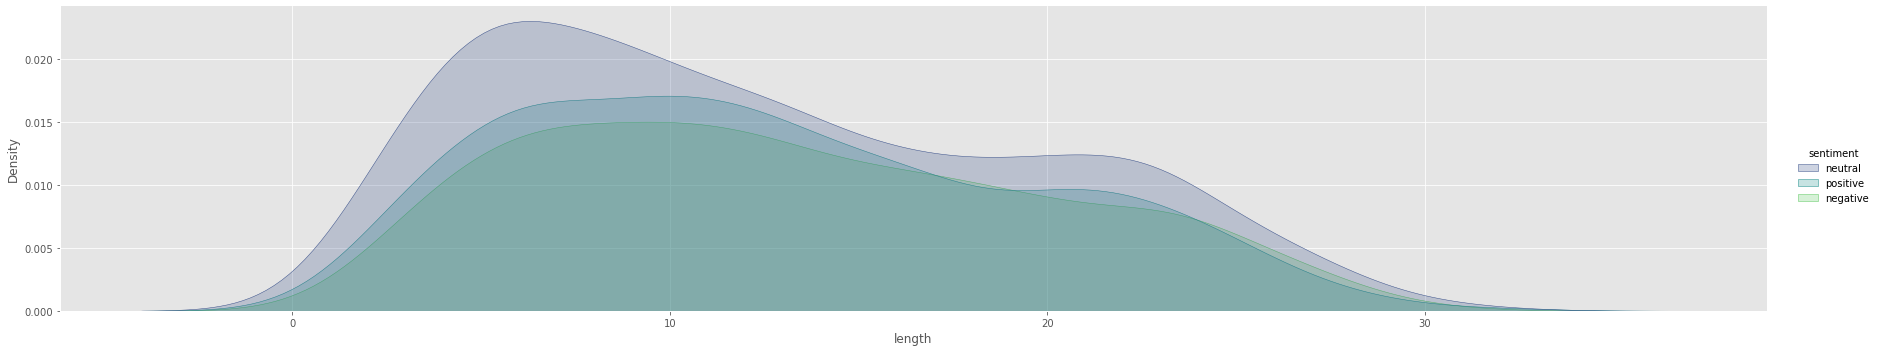

In [23]:
# plot the length of test tweet text across the sentiment....
plt.figure(figsize=(10,8))
sns.displot(data = test, x = "length", hue = "sentiment",
           kind = "kde", fill = True, aspect = 5, palette = "viridis");

In [24]:
# let's drop the selected_text column 
train.drop("selected_text",axis=1,inplace=True)

In [25]:
train.head(10)

,textID,text,sentiment,length
0,cb774db0d1,"I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,10
2,088c60f138,my boss is bullying me...,negative,5
3,9642c003ef,what interview! leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,14
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,neutral,12
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,positive,14
7,50e14c0bb8,Soooo high,neutral,2
8,e050245fbd,Both of you,neutral,3
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,positive,10


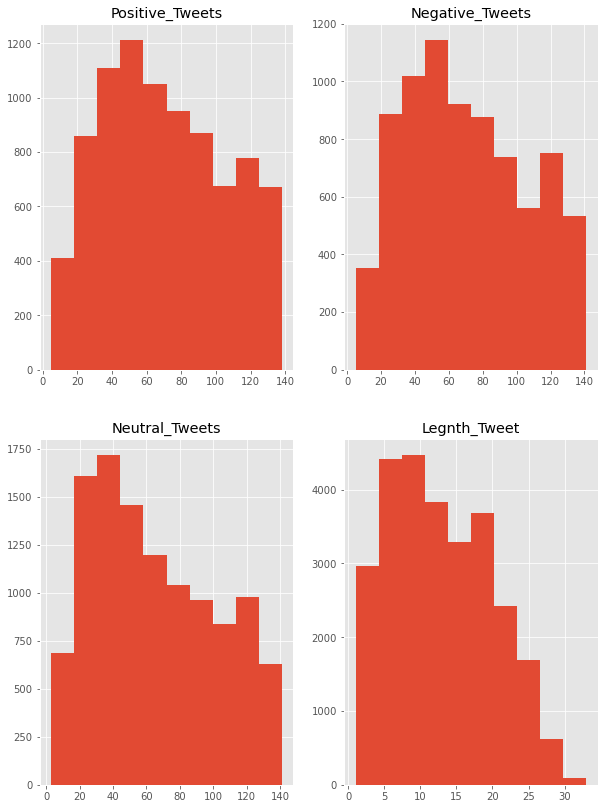

In [26]:
# plotting the number of characters in tweet per sentiment...

# positive tweet lenth
len_positive = train[train['sentiment']=="positive"]['text'].str.len()

# negative tweet length
len_negative = train[train["sentiment"]=="negative"]["text"].str.len()

# neutral tweet length
len_neutral = train[train["sentiment"]=="neutral"]["text"].str.len()

fig,ax = plt.subplots(2,2,figsize=(10,14))

# plotting positive tweet
ax[0,0].hist(len_positive)
ax[0,0].set_title("Positive_Tweets")

# plotting negative tweet
ax[0,1].hist(len_negative)
ax[0,1].set_title("Negative_Tweets")

# plotting positive tweet
ax[1,0].hist(len_neutral)
ax[1,0].set_title("Neutral_Tweets")

# plotting the overall length of tweets...
ax[1,1].hist(train["length"])
ax[1,1].set_title("Legnth_Tweet");

In [27]:
# now it's time to clean text, so let's make a function for it...
def clean_text(text):
    
    # convert text into lower
    text = str(text).lower()
    
    #     remove urls
    text = re.sub(r"https:\S+"," ",text)
    
    #     remove punctuation
    text = re.sub(r"[^\w\s]","",text)
    
    #     remove mentions
    text = re.sub(r'@\w+', " ", text)
    
    #     remove hashtags
    text = re.sub("#\w+"," ", text)
    
    #     remove digits
    text = re.sub(r"\d+"," ", text)
    
    #     remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
        
    return text 


In [28]:
# apply the function to train df
train["clean_text"] = train["text"].apply(lambda x : clean_text(x))

train.sample(10)

,textID,text,sentiment,length,clean_text
2970,37051dddd9,awwwwww i wish her to be safe while shes gone...,negative,21,awwwwww i wish her to be safe while shes gone...
20029,80666ae17f,In a Drill Sergeant`s voice: everybody wake th...,negative,23,in a drill sergeants voice everybody wake the ...
25019,de47ece87c,No twitpic? lol,neutral,3,no twitpic lol
4348,ddbc804570,i KNOW! AHH! so fun!,positive,5,i know ahh so fun
13763,c5480ac431,u said u was gonna follow its nita from ur l...,neutral,12,u said u was gonna follow its nita from ur l...
5289,412296c6c4,I`m in the Starbucks with a cup of coffee ht...,neutral,10,im in the starbucks with a cup of coffee htt...
24062,49cd042b83,Iï¿½m really desappointed...,negative,3,iï½m really desappointed
1337,74e9f8da6b,I think I should hire one of those tranlsators...,negative,15,i think i should hire one of those tranlsators...
488,e6c988afb8,Home until tomorrow. Did my running and spinni...,negative,19,home until tomorrow did my running and spinnin...
2505,68f79be259,Right here! Army Wife in Germany! I can`t STA...,negative,16,right here army wife in germany i cant stand ...


In [29]:
# apply it to test data as well
test["clean_text"] = test["text"].apply(lambda x : clean_text(x))

test.sample(10)

,textID,text,sentiment,length,clean_text
666,c860b3f840,i hope that everyone has been having a great w...,neutral,22,i hope that everyone has been having a great w...
2022,f6e3a6dd55,_Claire LOL I will buy u some big star wars p...,neutral,14,_claire lol i will buy u some big star wars p...
320,99fcc18a8d,Download movie 'A Good Day to Be Black &#38 S...,positive,13,download movie a good day to be black sexy ...
2054,1d428212cb,texting my friends and being bored... gosh i...,negative,10,texting my friends and being bored gosh i ha...
1412,92866f7b8c,Thank you!,positive,2,thank you
1374,8c03f75944,- ****. LOL ON FRIDAY.? ITS NOW SATURDAY HERE...,neutral,13,lol on friday its now saturday here lol im ...
3277,e976f2769d,If it`s any consolation I`ve had to abandon t...,positive,17,if its any consolation ive had to abandon the...
3447,a5912f5b7b,Gday... Do you know if NHibernate has issues w...,neutral,21,gday do you know if nhibernate has issues with...
955,458f7b2493,finally feel back into swing of things here at...,positive,23,finally feel back into swing of things here at...
2963,08ad89c6b0,Hi .. I have the net YAYY.. Im here for a shor...,positive,14,hi i have the net yayy im here for a short ti...


In [30]:
# setting stopwords
stop=set(stopwords.words('english'))

Text(0.5, 0.98, 'Common words in tweet text')

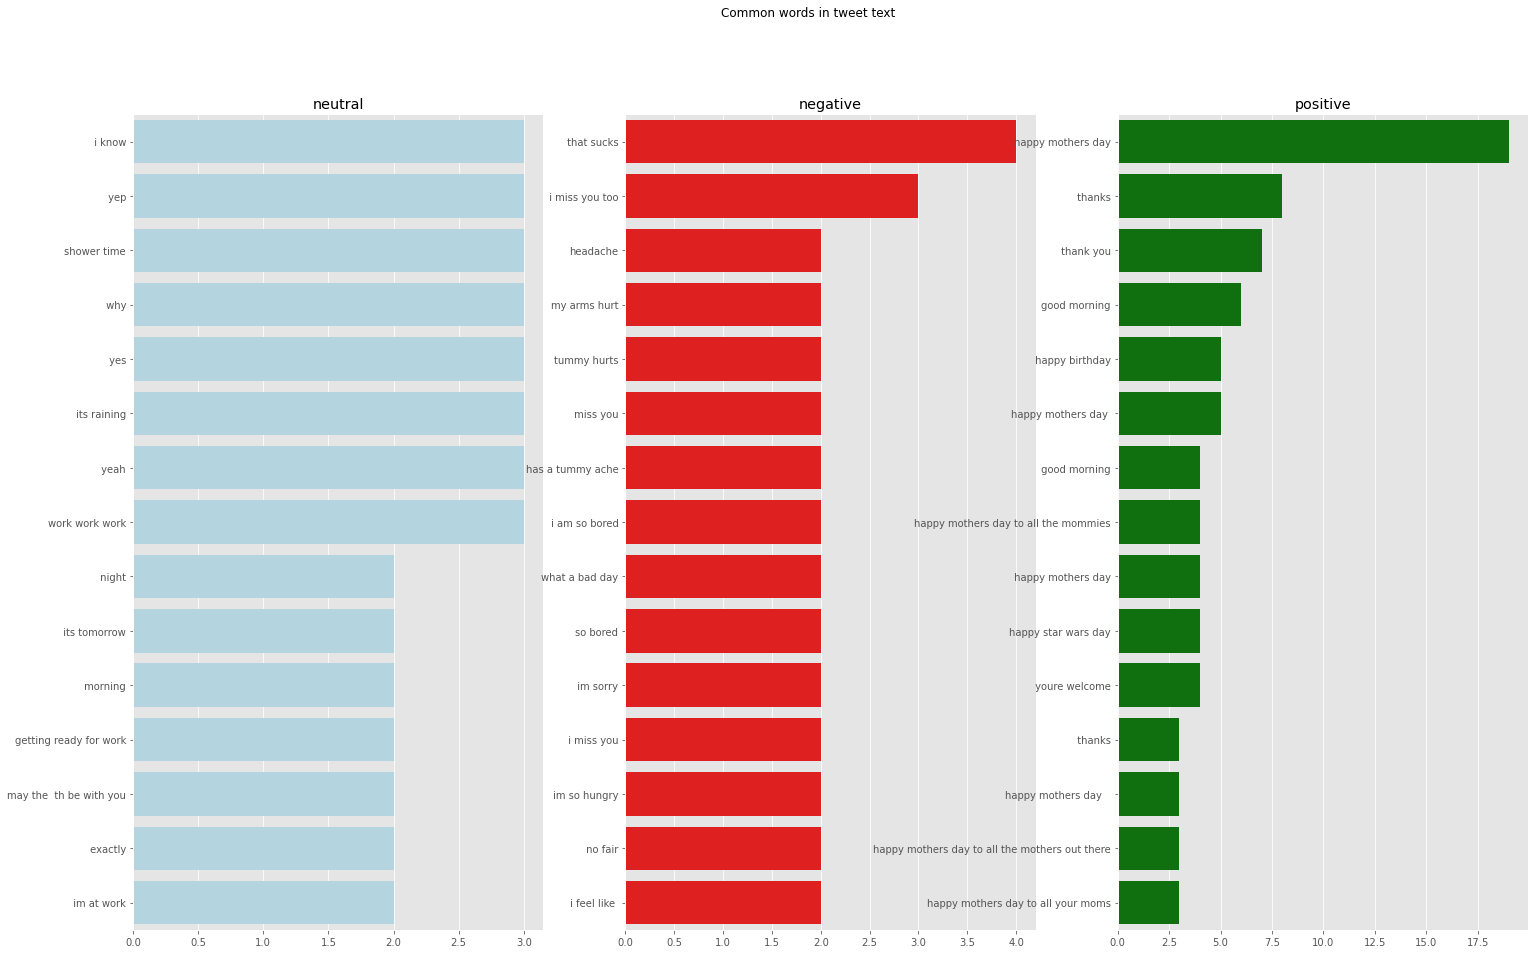

In [31]:
# let's find out the most common words in the text.....
sentiments = train["sentiment"].unique()

# setup the figure
fig,ax = plt.subplots(1,3, figsize=(25,15))
colors = ["lightblue","red","green",]
for i in range(3):
    new = train[train["sentiment"]==sentiments[i]]["clean_text"]
    counter = Counter(new)
    most_common = counter.most_common()
    x = []
    y = []
    
    for word,count in most_common[:15]:
        x.append(word)
        y.append(count)
        
    sns.barplot(x=y,y=x,ax=ax[i], color = colors[i])
    ax[i].set_title(sentiments[i])
fig.suptitle("Common words in tweet text")

In [32]:
# pick the main columns....
train_text = train["clean_text"]
train_labels = train["sentiment"]

test_text = test["clean_text"]
test_labels = test["sentiment"]

In [33]:
# as our label is in text so map it

l = {"neutral" : 0, "positive" : 1,"negative" : 2}

# apply it to the data....

train_labels = train_labels.map(l)
test_labels = test_labels.map(l)

In [34]:
train_text

0                        id have responded if i were going
1               sooo sad i will miss you here in san diego
2                                   my boss is bullying me
3                            what interview leave me alone
4         sons of  why couldnt they put them on the rel...
                               ...                        
27476     wish we could come see u on denver  husband l...
27477     ive wondered about rake to  the client has ma...
27478     yay good for both of you enjoy the break  you...
27479                                but it was worth it  
27480       all this flirting going on  the atg smiles ...
Name: clean_text, Length: 27480, dtype: object

# Tokenization : 
    As we clean our text let's split the data and convert each split into integer through tokenization because our deep learning models works only with the numbers....



In [35]:
# find the average length of sentence...
round(np.mean(train["length"]))

13

In [36]:
# setup the vocabulary length...
max_token = 15000
max_len = 15


token = TextVectorization(max_tokens = max_token,
                         standardize = "lower_and_strip_punctuation",
                         output_mode = "int",
                         output_sequence_length = max_len,
                         split = "whitespace")

# adapt to text
token.adapt(train_text)

Metal device set to: Apple M1


2022-10-15 21:17:32.906409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-15 21:17:32.906851: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-15 21:17:32.945645: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-15 21:17:32.994843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [37]:
# get some text information....
vocab = token.get_vocabulary()
print(f"Total words in the Vocabulary : {len(vocab)}")
print(f"Top five words in the Vocabulary : {vocab[:5]}")
print(f"Bottom five words in the Vocabulary : {vocab[-5:]}")

Total words in the Vocabulary : 15000
Top five words in the Vocabulary : ['', '[UNK]', 'i', 'to', 'the']
Bottom five words in the Vocabulary : ['rightards', 'rigby', 'rig', 'rieger', 'ridin']


In [38]:
# let's tokenize some sentence....
random_index = np.random.randint(0,len(train_text))
random_sentence = train_text[random_index]

print(f"Original Text : {random_sentence}\n")
print(f"Tokenize Sentence : {token([random_sentence])}")

Original Text :  have fun tonight

Tokenize Sentence : [[ 17 101 117   0   0   0   0   0   0   0   0   0   0   0   0]]


# Embedding
   
  A word embedding is a class of approaches for representing words and documents using a dense vector representation. Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn

In [39]:
embedd = Embedding(input_dim = max_token,
                  output_dim = 256,
                   input_length = max_len,
                   embeddings_initializer = "uniform",
                  )

In [40]:
# let's tokenize and embedd some sentence....
random_index = np.random.randint(0,len(train_text))
random_sentence = train_text[random_index]

print(f"Original Text : {random_sentence}\n")
print(f"Tokenize Sentence : {token([random_sentence])}\n")
print(f"Tokenize Sentence : {embedd(token([random_sentence]))}")

Original Text :  thanks for the tip its our company laptops so was aiming for another solution actually

Tokenize Sentence : [[  84   12    4 1758   25  191  869 4859   18   28 6890   12  192 3914
   261]]

Tokenize Sentence : [[[-0.00269823  0.02061    -0.04971485 ...  0.04537146  0.00913843
   -0.03243618]
  [-0.02687665 -0.04616083  0.01390092 ...  0.00190409  0.04501334
   -0.02660265]
  [-0.00469453 -0.0024895   0.00419755 ... -0.0227523  -0.03274585
    0.04473131]
  ...
  [ 0.02096147  0.03109289 -0.02387471 ...  0.04523328 -0.01082517
    0.01217182]
  [-0.00417464 -0.00531899  0.03473271 ...  0.00633035  0.02855365
   -0.02695122]
  [ 0.0100122  -0.02674328 -0.02620647 ...  0.01371297  0.01530559
    0.0431041 ]]]


In [41]:
# let's make a function to evaluate our model performance....
def calculate_results(y_true,y_pred):
    """
    This function will evaluate our model performace by measuring certain metrics....
    Accuracy : it tells us that how accurately our model predict the label
    Precision : this is the ability of classifier not to label a negative label as positive.
    Recall : this is the ability of classifier to find all positive labels.
    Fscore : this is the average of preicision and recall.
    """
    accuracy = accuracy_score(y_true,y_pred)
    precision_score,recall_score,f_score,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    
    results = {
        "Accuracy" : accuracy ,
        "Precision" : precision_score,
        "Recall" : recall_score,
        "F_Score" : f_score
    }
    return results

# Modelling : 
     
     We'll build a series of model and pick the one that performs better.
    ~Naive Model
    ~Dense Model
    ~LSTM Model
    ~GRU Model

In [42]:
# Model_0 : Naive Model

In [43]:
# let's build our first sklearn naive model...
model_0 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ("naive",MultinomialNB())
])

# fitting model to data....
model_0.fit(train_text,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('naive', MultinomialNB())])

In [44]:
# calculate model results....
model_0_results = calculate_results(test_labels,model_0.predict(test_text))
model_0_results

{'Accuracy': 0.620826259196378,
 'Precision': 0.6920038667463424,
 'Recall': 0.620826259196378,
 'F_Score': 0.6084458841291476}

In [60]:
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels,3)


# Model 2 : Simple Dense Model

In [61]:
# let's build our first dense model.....

# set up the random seed....
tf.random.set_seed(42)

# define the inputs....
inputs = layers.Input(shape=(),dtype="string")

# pass inputs to tokenization layer....
x = token(inputs)

# pass the token to embeddings....
x = embedd(x)

# hidden layers...
x = layers.Dense(64,activation="relu")(x)

# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)
# adding the globalaverage layer...
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_1 = tf.keras.Model(inputs,output,name="Dense_Model")

# compiling the model...
model_1.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [62]:
# model summary.....
model_1.summary()

Model: "Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 dense_12 (Dense)            (None, 15, 64)            16448     
                                                                 
 dense_13 (Dense)            (None, 15, 32)            2080      
                                                                 
 global_average_pooling1d_4   (None, 32)               0         
 (GlobalAveragePooling1D)                              

In [64]:
# fitting the model to data....
history_1 = model_1.fit(train_text,train_labels,
                       epochs=10,
                       validation_data=(test_text,test_labels),
                        validation_split = int(len(test_text) * 0.25),
                        callbacks = [tf.keras.callbacks.ModelCheckpoint("Dense_1.tf",
                                                                               save_best_only=True)])

Epoch 1/10
859/859 [==============================] - 19s 22ms/step - loss: 0.6850 - accuracy: 0.7265 - val_loss: 0.7464 - val_accuracy: 0.6975
Epoch 2/10
859/859 [==============================] - 18s 20ms/step - loss: 0.6269 - accuracy: 0.7547 - val_loss: 0.7635 - val_accuracy: 0.6760
Epoch 3/10
859/859 [==============================] - 18s 20ms/step - loss: 0.5857 - accuracy: 0.7764 - val_loss: 0.7766 - val_accuracy: 0.6805
Epoch 4/10
859/859 [==============================] - 18s 20ms/step - loss: 0.5555 - accuracy: 0.7879 - val_loss: 0.7948 - val_accuracy: 0.6780
Epoch 5/10
859/859 [==============================] - 18s 20ms/step - loss: 0.5318 - accuracy: 0.7992 - val_loss: 0.8254 - val_accuracy: 0.6689
Epoch 6/10
859/859 [==============================] - 18s 20ms/step - loss: 0.5181 - accuracy: 0.8082 - val_loss: 0.8390 - val_accuracy: 0.6681
Epoch 7/10
859/859 [==============================] - 18s 21ms/step - loss: 0.5026 - accuracy: 0.8127 - val_loss: 0.8565 - val_accuracy:

In [67]:
os.listdir("Dense_1.tf")

['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']

In [68]:
# let's load the best model...
model_2 = tf.keras.models.load_model("Dense_1.tf")

2022-10-15 21:43:29.711748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 21:43:29.716933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [72]:
# make predictions and calculate the results...
model_2_results = calculate_results(test_labels,tf.squeeze(tf.round(model_2.predict(test_text))))
model_2_results

111/111 [==============================] - 0s 4ms/step


{'Accuracy': 0.6301641199773628,
 'Precision': 0.7261887709362999,
 'Recall': 0.6301641199773628,
 'F_Score': 0.674466392261605}

In [81]:
# let's make a function that will plot the model performance......
def plot_model_performance(history):
    
    loss = history.history["loss"]
    
    val_loss = history.history["val_loss"]
    
    acc = history.history["accuracy"]
    
    val_acc = history.history["val_accuracy"]
    
    epochs = range(len(loss))
    
    
#     plottint the model accuracy vs validation accuracy
    plt.plot(epochs,acc,label="Training Accuracy",marker = "*",linestyle = "dotted")
    plt.plot(epochs,val_acc,label="Validation Accuracy",marker = "P", linestyle = "dashed")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.legend(title="Accuracy")
    
    
#     plotting the training vs validation loss
    plt.figure()
    plt.plot(epochs,loss,label="Training Loss",marker="1", linestyle = "dotted")
    plt.plot(epochs,val_loss,label="Validation Loss",marker = "2", linestyle = "dashed")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.legend(title="Loss")
    plt.show()

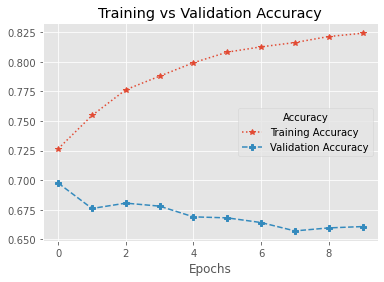

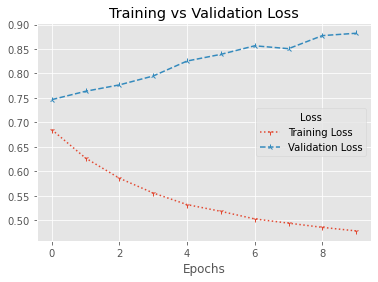

In [82]:
# plot the model performance...
plot_model_performance(history_1)

# Model 3 : LSTM

In [86]:
# let's build the 3rd Model LSTM (Long-Short-Term-Memory)

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# hidden layer.....
x = layers.Dense(64,activation="relu")(x)
# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)
# adding the lstm layer
x = layers.LSTM(64,return_sequences=True)(x)

# adding the drop-out layer...
x = layers.Dropout(0.1)(x)

# LSTM layer
x = layers.LSTM(32,)(x)

# output layer....
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_3 = tf.keras.Model(inputs,output,name="LSTM_Model")

# compiling the model...
model_3.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [87]:
# model summary....
model_3.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 dense_18 (Dense)            (None, 15, 64)            16448     
                                                                 
 dense_19 (Dense)            (None, 15, 32)            2080      
                                                                 
 lstm_2 (LSTM)               (None, 15, 64)            24832     
                                                        

In [88]:
# fitting the model to data....
history_3 = model_3.fit(train_text, train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.25),
                        callbacks = [tf.keras.callbacks.ModelCheckpoint("LSTM.tf",
                                                                               save_best_only=True)])

Epoch 1/10


2022-10-15 22:35:42.189366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 22:35:42.447285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 22:35:43.469964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 22:35:43.652966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/859 [..............................] - ETA: 48:33 - loss: 1.1173 - accuracy: 0.2812

2022-10-15 22:35:44.157840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - ETA: 0s - loss: 0.5752 - accuracy: 0.7694

2022-10-15 22:36:13.733698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 22:36:13.838635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 22:36:13.885725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: LSTM.tf/assets


INFO:tensorflow:Assets written to: LSTM.tf/assets


859/859 [==============================] - 41s 44ms/step - loss: 0.5752 - accuracy: 0.7694 - val_loss: 0.8205 - val_accuracy: 0.6573
Epoch 2/10
859/859 [==============================] - 30s 35ms/step - loss: 0.4795 - accuracy: 0.8158 - val_loss: 0.8366 - val_accuracy: 0.6559
Epoch 3/10
859/859 [==============================] - 29s 34ms/step - loss: 0.4472 - accuracy: 0.8312 - val_loss: 0.8615 - val_accuracy: 0.6565
Epoch 4/10
859/859 [==============================] - 29s 33ms/step - loss: 0.4276 - accuracy: 0.8392 - val_loss: 0.8580 - val_accuracy: 0.6650
Epoch 5/10
859/859 [==============================] - 29s 34ms/step - loss: 0.4141 - accuracy: 0.8448 - val_loss: 0.8521 - val_accuracy: 0.6644
Epoch 6/10
859/859 [==============================] - 29s 34ms/step - loss: 0.4045 - accuracy: 0.8483 - val_loss: 0.8650 - val_accuracy: 0.6590
Epoch 7/10
859/859 [==============================] - 29s 34ms/step - loss: 0.3929 - accuracy: 0.8527 - val_loss: 0.9648 - val_accuracy: 0.6528
Epo

In [90]:
# make prediction and calculate results....
model_3_results = calculate_results(test_labels, tf.squeeze(tf.round(model_3.predict(test_text))))
model_3_results

111/111 [==============================] - 1s 9ms/step


{'Accuracy': 0.6329937747594794,
 'Precision': 0.6751993131125321,
 'Recall': 0.6329937747594794,
 'F_Score': 0.6527064136475653}

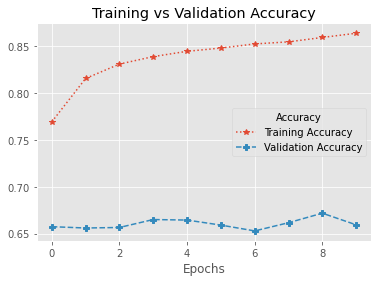

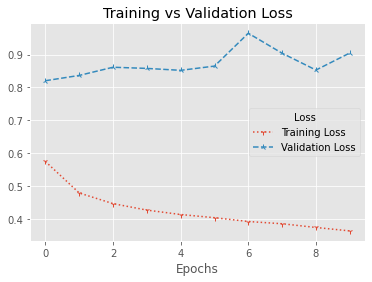

In [91]:
# plot model performance...
plot_model_performance(history_3)

# Model 4 : GRU

In [92]:
# let's build the Model GRU(Gated Recurrent Units)

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# hidden layer.....
x = layers.Dense(64,activation="relu")(x)

# adding drop-out layer....
x = layers.Dropout(0.1)(x)

# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)

# adding the lstm layer
x = layers.GRU(64,return_sequences=True)(x)

# adding the drop-out layer...
x = layers.Dropout(0.1)(x)

# LSTM layer
x = layers.GRU(32,)(x)

# output layer....
output = layers.Dense(3,activation="sigmoid")(x)

# model building....
model_4 = tf.keras.Model(inputs,output,name="LSTM_Model")

# compiling the model...
model_4.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [93]:
# model summary...
model_4.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 dense_21 (Dense)            (None, 15, 64)            16448     
                                                                 
 dropout_2 (Dropout)         (None, 15, 64)            0         
                                                                 
 dense_22 (Dense)            (None, 15, 32)            2080      
                                                        

In [97]:
# fitting the model to data....
history_4 = model_4.fit(train_text, train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.30))

Epoch 1/10
859/859 [==============================] - 32s 37ms/step - loss: 0.6247 - accuracy: 0.7392 - val_loss: 0.8643 - val_accuracy: 0.6171
Epoch 2/10
859/859 [==============================] - 33s 38ms/step - loss: 0.6228 - accuracy: 0.7389 - val_loss: 0.9045 - val_accuracy: 0.6112
Epoch 3/10
859/859 [==============================] - 32s 38ms/step - loss: 0.5975 - accuracy: 0.7551 - val_loss: 0.8832 - val_accuracy: 0.6285
Epoch 4/10
859/859 [==============================] - 32s 37ms/step - loss: 0.5713 - accuracy: 0.7685 - val_loss: 0.9082 - val_accuracy: 0.6242
Epoch 5/10
859/859 [==============================] - 33s 38ms/step - loss: 0.5730 - accuracy: 0.7676 - val_loss: 0.9048 - val_accuracy: 0.6203
Epoch 6/10
859/859 [==============================] - 32s 38ms/step - loss: 0.5762 - accuracy: 0.7686 - val_loss: 0.9076 - val_accuracy: 0.6222
Epoch 7/10
859/859 [==============================] - 32s 37ms/step - loss: 0.5730 - accuracy: 0.7721 - val_loss: 0.9381 - val_accuracy:

In [98]:
# make prediction and calculate results....
model_4_results = calculate_results(test_labels, tf.squeeze(tf.round(model_4.predict(test_text))))
model_4_results

111/111 [==============================] - 1s 9ms/step


{'Accuracy': 0.2416525183927561,
 'Precision': 0.49978775434414197,
 'Recall': 0.8217317487266553,
 'F_Score': 0.6172838223710903}

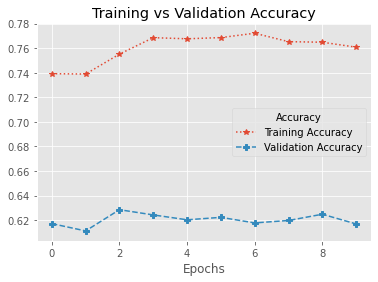

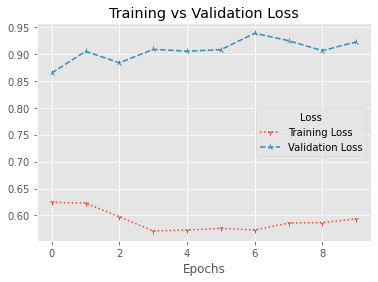

In [99]:
# plot model performance....
plot_model_performance(history_4)

# Model 5 : BiDirectional 

In [105]:
# let's build the BiDirectional Model....

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# adding the Bidirectional layer
x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)

# Bidirectional layer
x = layers.Bidirectional(layers.LSTM(32,))(x)

# output layer....
output = layers.Dense(3,activation="sigmoid")(x)

# model building....
model_5 = tf.keras.Model(inputs,output,name="LSTM_Model")

# compiling the model...
model_5.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [106]:
# model summary....
model_5.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 15, 128)          164352    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                        

In [107]:
# fitting model to data...
history_5 = model_5.fit(train_text, train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.30))

Epoch 1/10


2022-10-15 23:41:43.803648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:41:44.241770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:41:44.253277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:41:44.389229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:41:44.399331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:41:44.592483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:41:44.608263: I tensorflow/core/grappler/optimizers/cust

859/859 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.8111

2022-10-15 23:42:26.531842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:42:26.663548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:42:26.670779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:42:26.763808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:42:26.771083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - 47s 51ms/step - loss: 0.4941 - accuracy: 0.8111 - val_loss: 0.8505 - val_accuracy: 0.6621
Epoch 2/10
859/859 [==============================] - 40s 47ms/step - loss: 0.4019 - accuracy: 0.8517 - val_loss: 0.8841 - val_accuracy: 0.6587
Epoch 3/10
859/859 [==============================] - 42s 49ms/step - loss: 0.3612 - accuracy: 0.8675 - val_loss: 0.9013 - val_accuracy: 0.6630
Epoch 4/10
859/859 [==============================] - 42s 49ms/step - loss: 0.3280 - accuracy: 0.8809 - val_loss: 0.9662 - val_accuracy: 0.6636
Epoch 5/10
859/859 [==============================] - 41s 48ms/step - loss: 0.2967 - accuracy: 0.8914 - val_loss: 0.9582 - val_accuracy: 0.6621
Epoch 6/10
859/859 [==============================] - 42s 49ms/step - loss: 0.2646 - accuracy: 0.9044 - val_loss: 1.0424 - val_accuracy: 0.6573
Epoch 7/10
859/859 [==============================] - 41s 48ms/step - loss: 0.2312 - accuracy: 0.9190 - val_loss: 1.0997 - val_accuracy: 0.6553
Epo

In [108]:
# make predictions and calculate results....
model_5_results = calculate_results(test_labels,tf.squeeze(tf.round(model_5.predict(test_text))))
model_5_results

2022-10-15 23:50:26.963805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:50:27.112119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:50:27.132859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  3/111 [..............................] - ETA: 3s  

2022-10-15 23:50:27.254185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-15 23:50:27.261888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 3s 16ms/step


{'Accuracy': 0.5684776457272213,
 'Precision': 0.6135321407244625,
 'Recall': 0.7068477645727221,
 'F_Score': 0.6562491513993478}

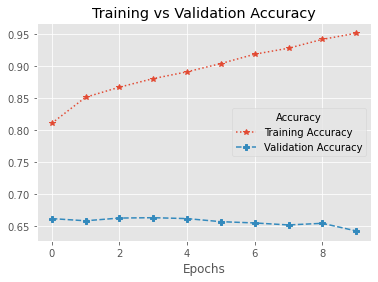

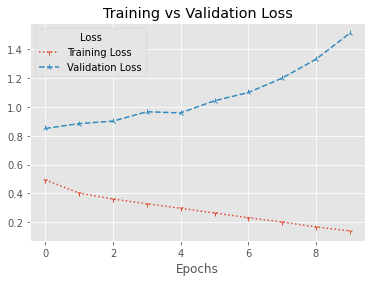

In [109]:
# plot model performance....
plot_model_performance(history_5)